# PR Term Project - Cuisine Classify

## Load Data

In [1]:
import pandas as pd
import re
import nltk
import ast
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
df_train = pd.read_csv('new_train.csv')
df_test = pd.read_csv('new_val.csv')

def ast_string_to_list(df):
    for i,j in enumerate(df['ingredients']):
        ast_j = ast.literal_eval(j)
        df.at[i , 'ingredients'] = ast_j

ast_string_to_list(df_train)
ast_string_to_list(df_test)

df_train.head(5)

id                                        ingredients  cuisine
0  33507  [olive oil, crushed red pepper flakes, red bel...  italian
1  29784  [parsley sprigs, salt, fresh sage, olive oil, ...   french
2  13963  [olive oil, red wine vinegar, red bell pepper,...   french
3  39458  [unbaked pie crusts, heavy cream, onions, grou...   french
4  29000  [fishcake, sesame seeds, garlic, sugar, water,...   korean

## Exploratory Data Analysis

In [2]:
print("Total # of train data \t\t{}".format(len(df_train)))
print("Total # of test data \t\t{}".format(len(df_test)))

cs_list = df_train["cuisine"].unique()
print("Total # of cuisine \t\t{}".format(len(cs_list)))

ing_enum = set()
ing_count = 0
for x in df_train['ingredients']:
    for y in x:
        ing_enum.add(y)
        ing_count += 1

print("Unique ingredients \t\t{}".format(len(ing_enum)))
print("Avg ingredients per data \t{:.2f}".format(ing_count/len(df_train)))

Total # of train data 		31819
Total # of test data 		7955
Total # of cuisine 		20
Unique ingredients 		6325
Avg ingredients per data 	10.78


### Category Distribution

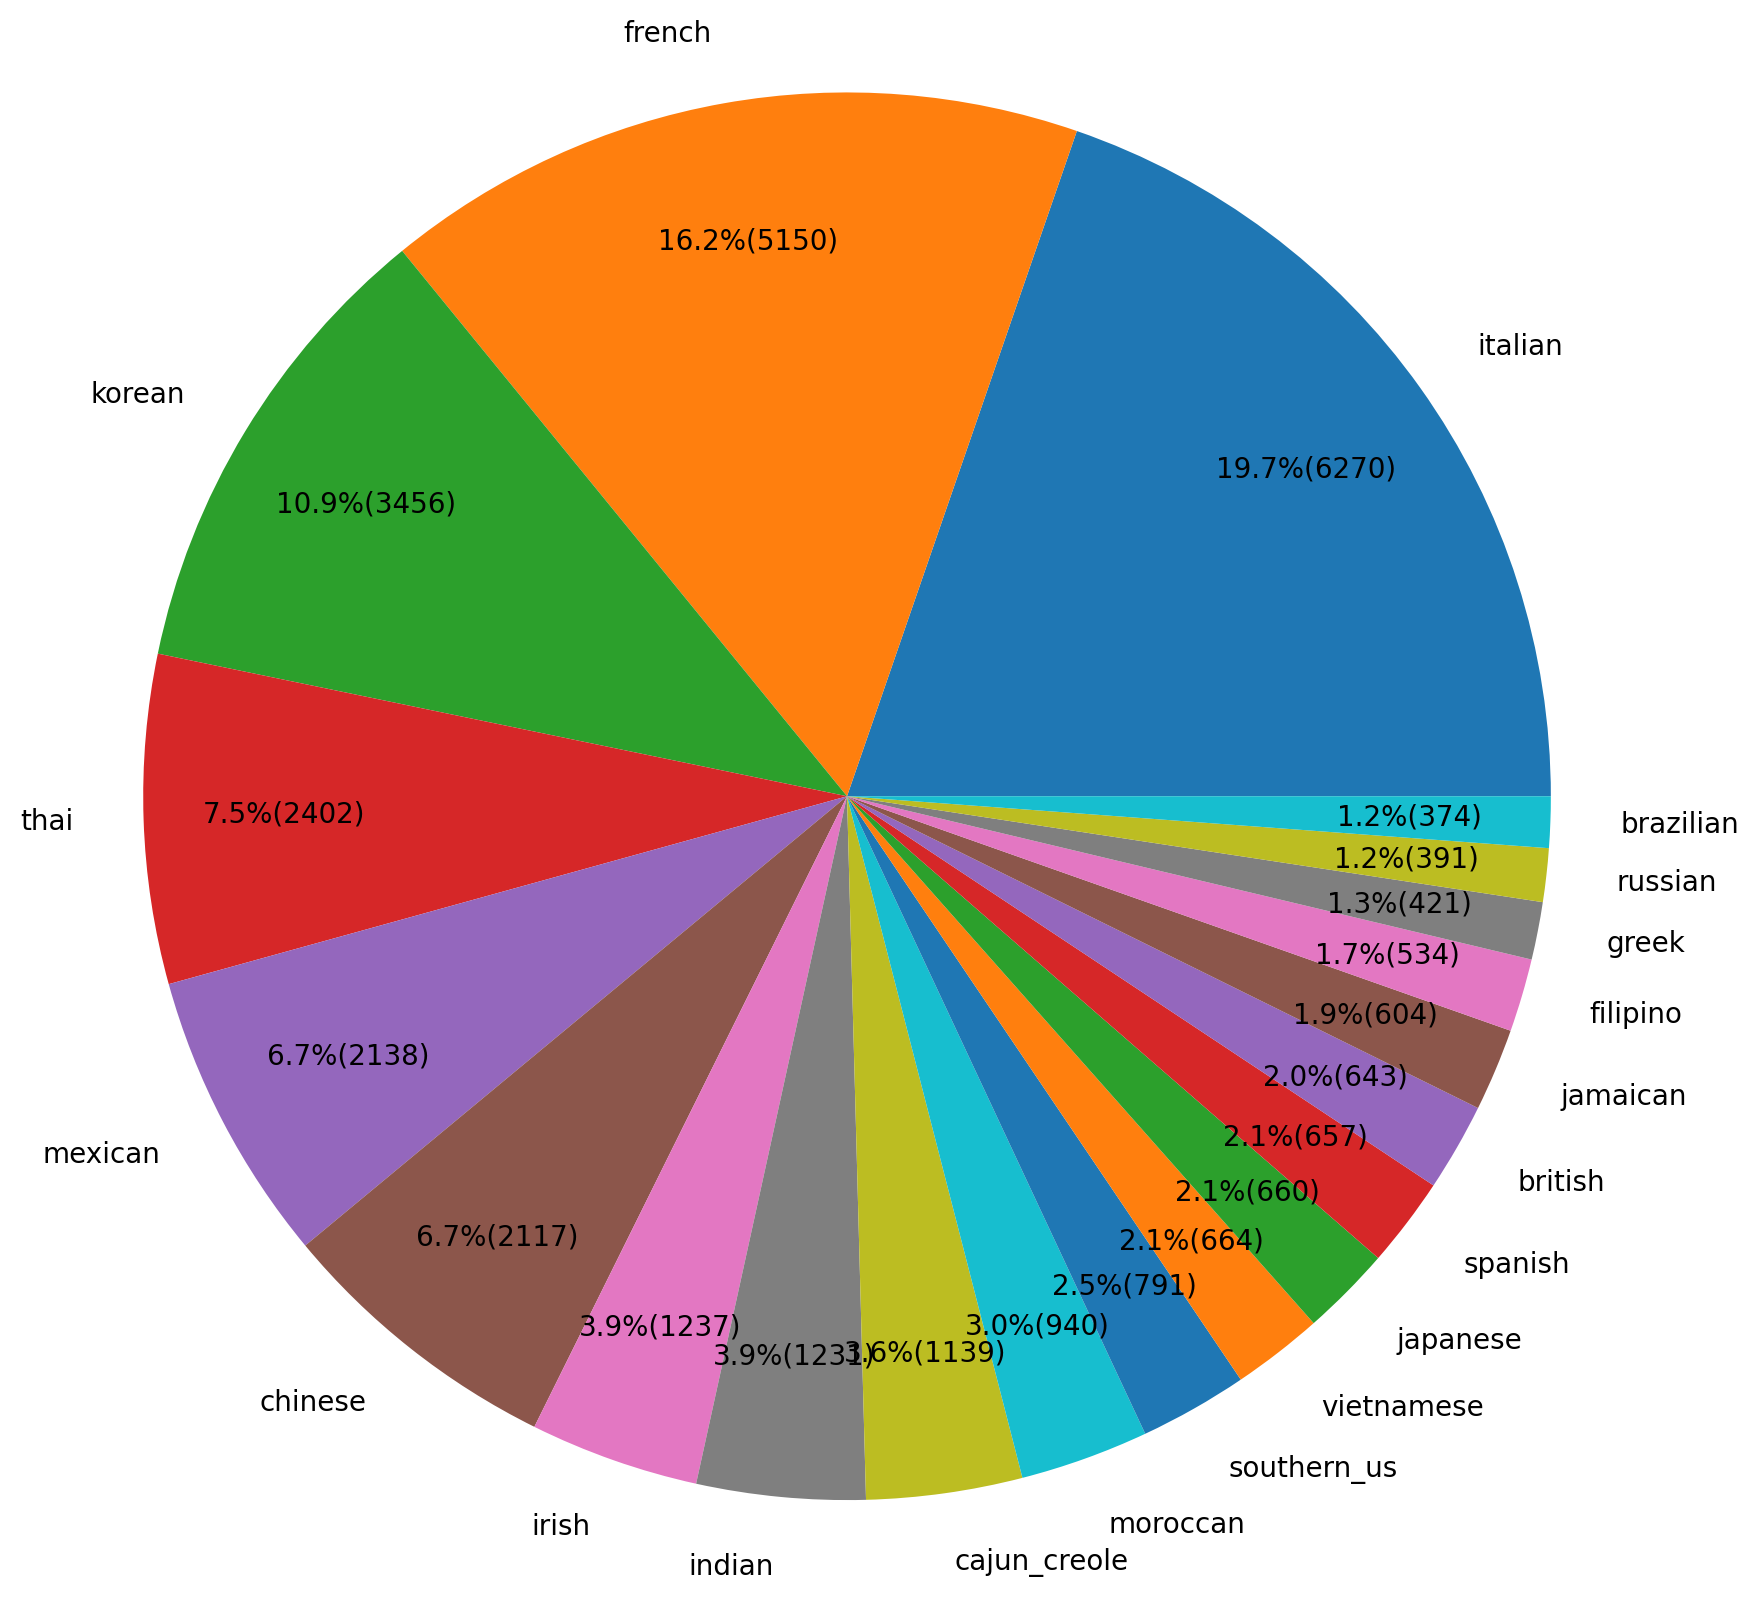

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10),dpi=200)

labels = df_train["cuisine"].unique()
size = df_train["cuisine"].value_counts()
per = round(df_train["cuisine"].value_counts(normalize=True)*100, 2)

plt.pie(size,
        labels = labels,
        autopct = lambda i: '{:.1f}%({:.0f})'.format(i,i*sum(size)/100),
        pctdistance = 0.8,
        textprops = {"fontsize" : 10})

plt.axis('equal')
plt.show()

### TOP 20 ingredients - cuisine wise

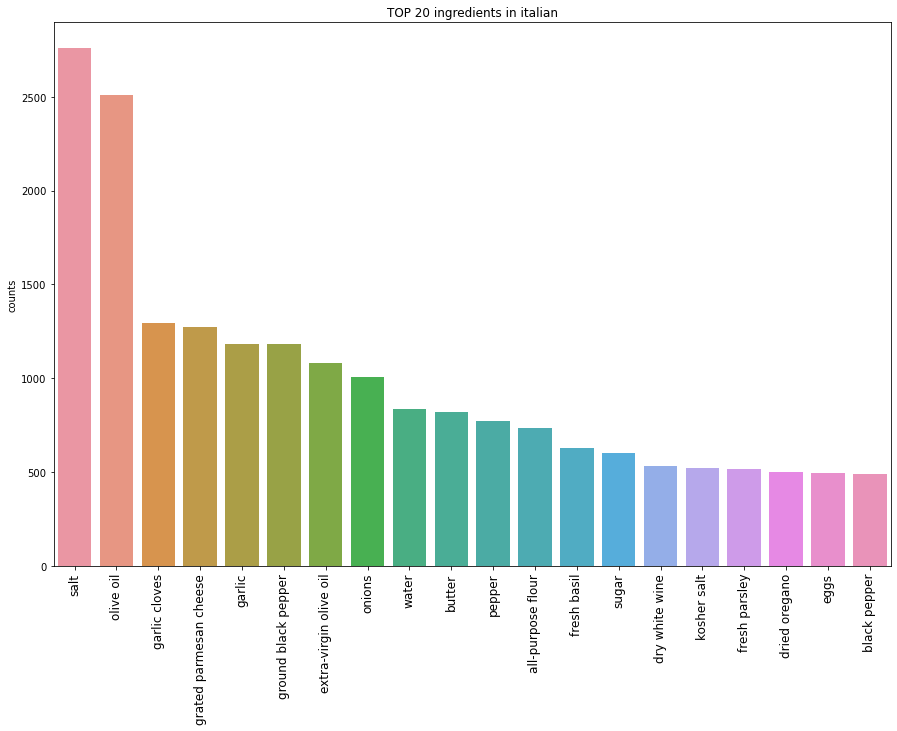

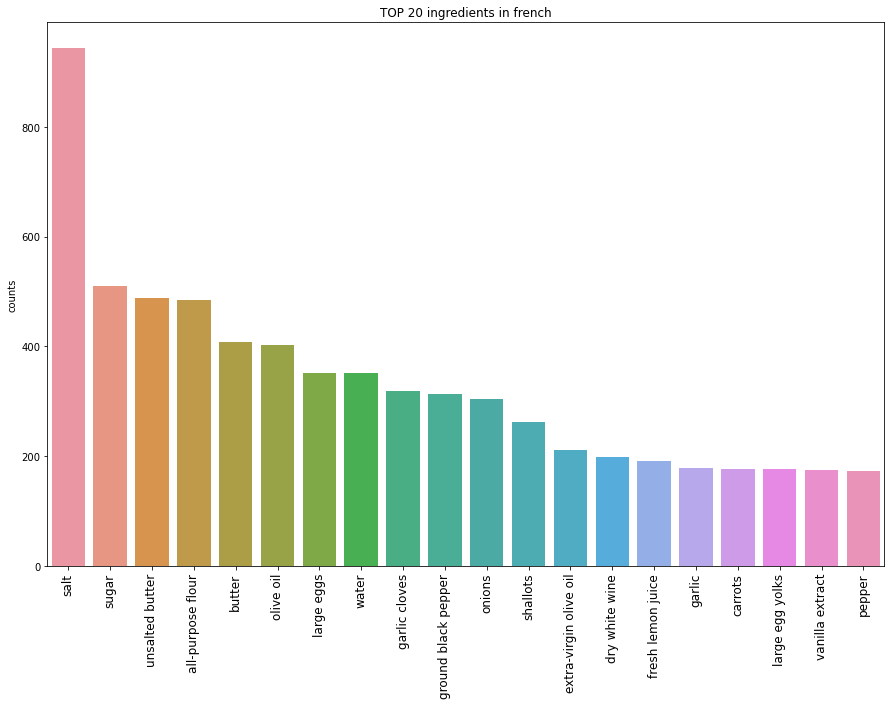

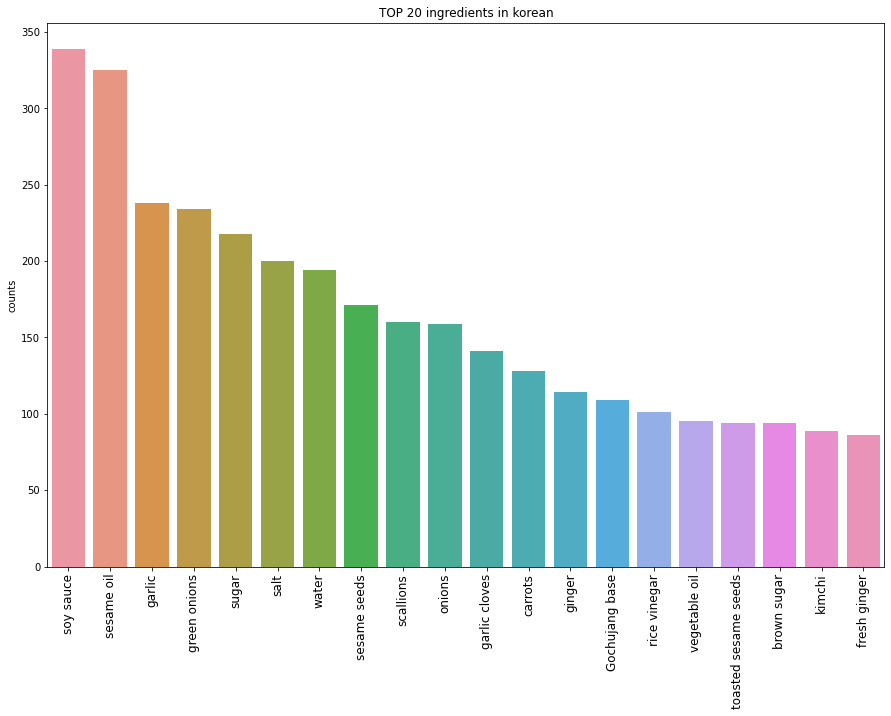

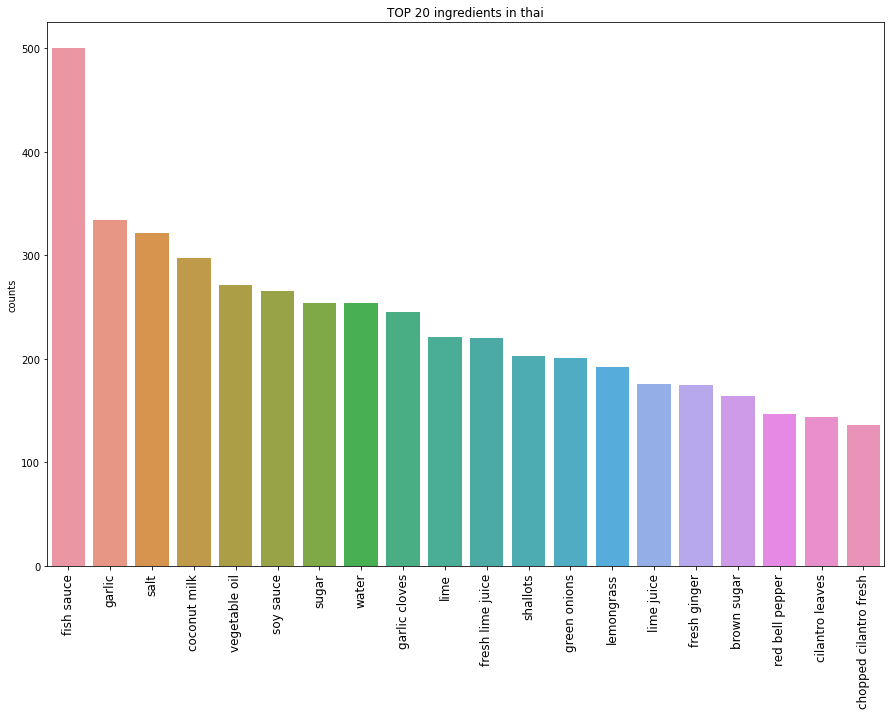

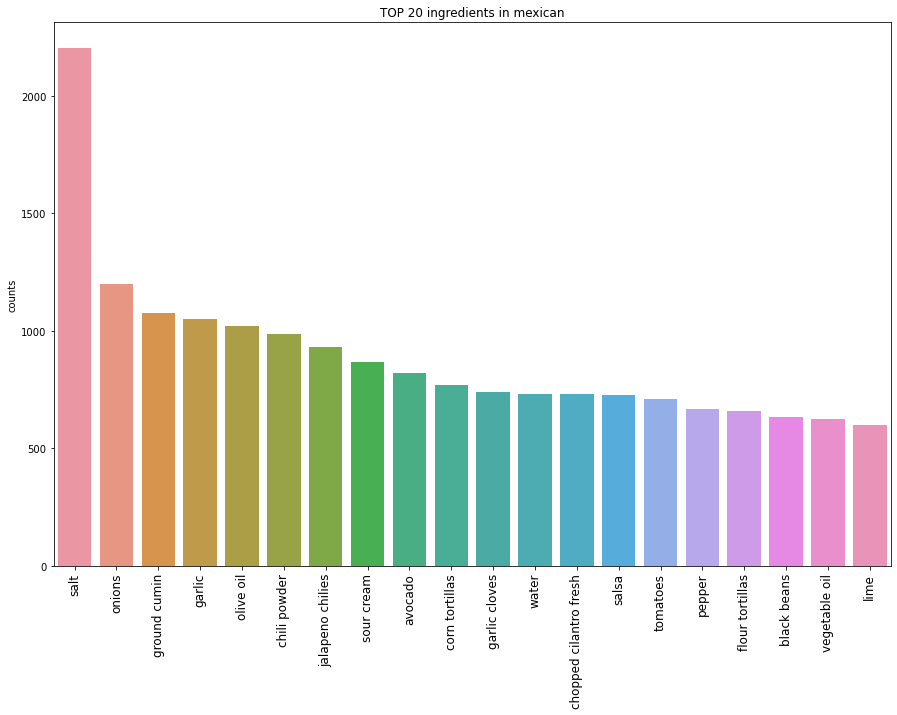

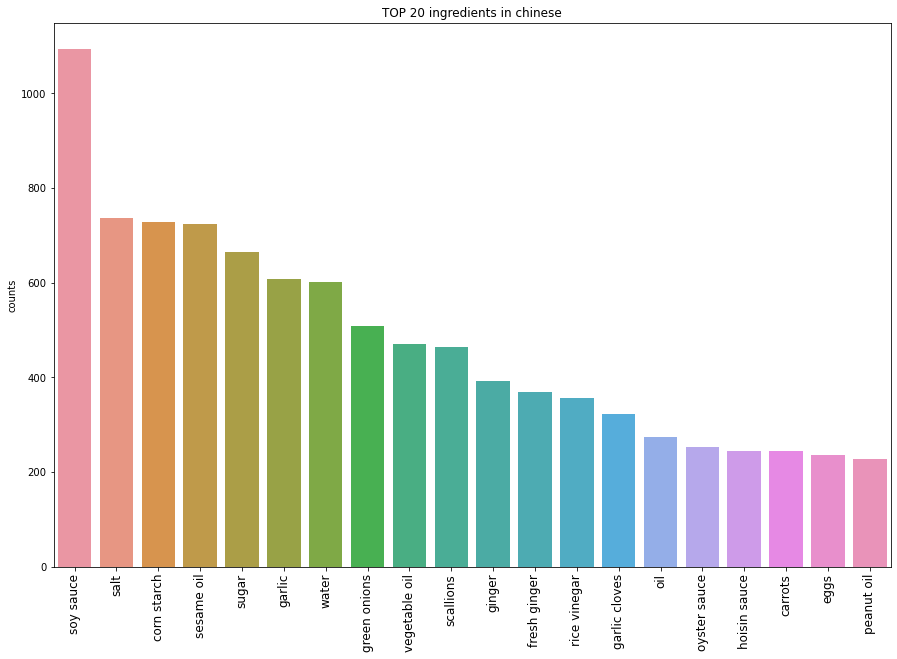

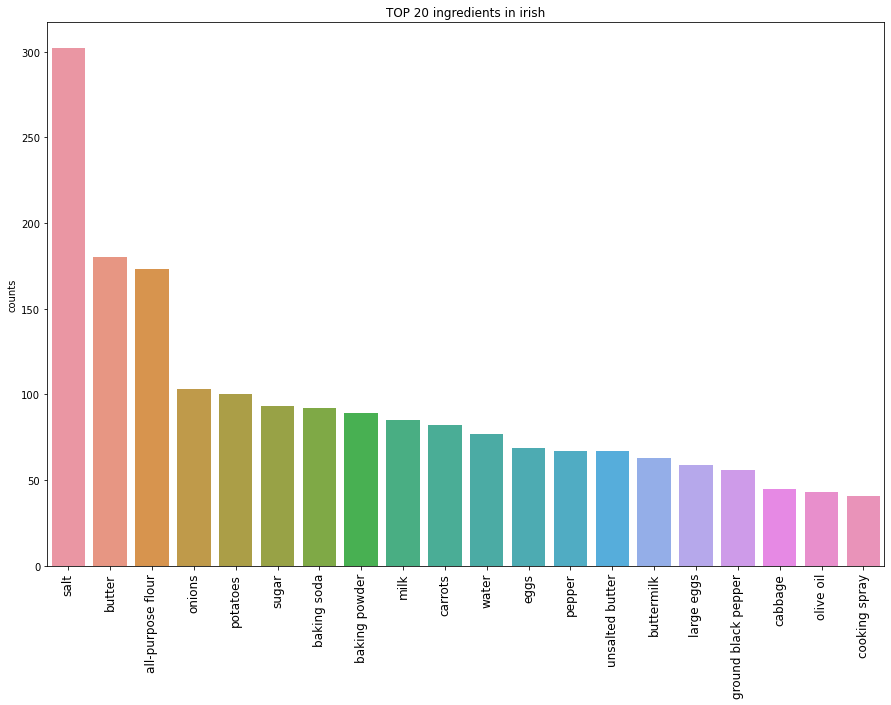

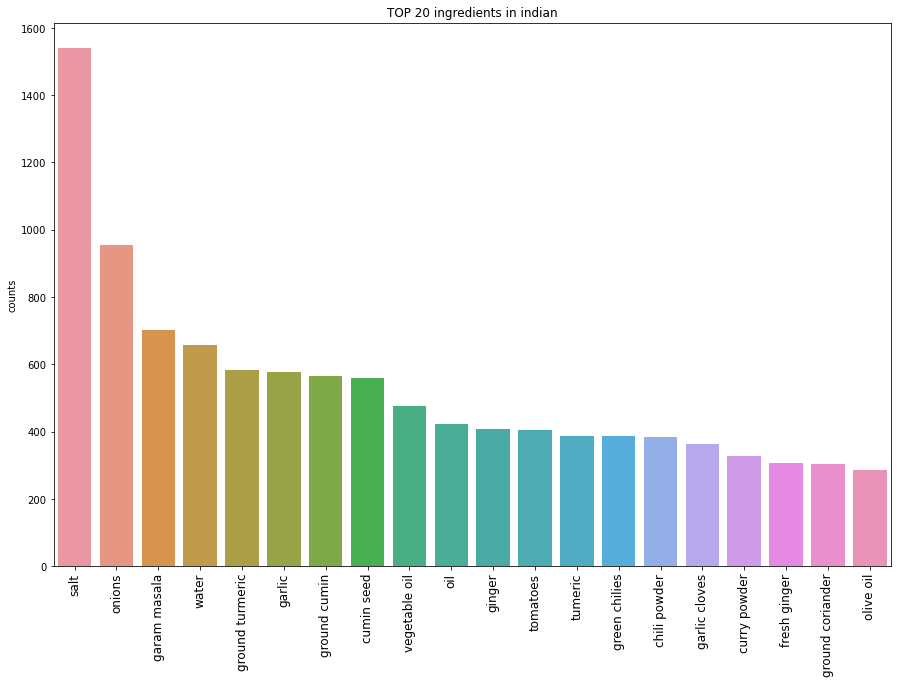

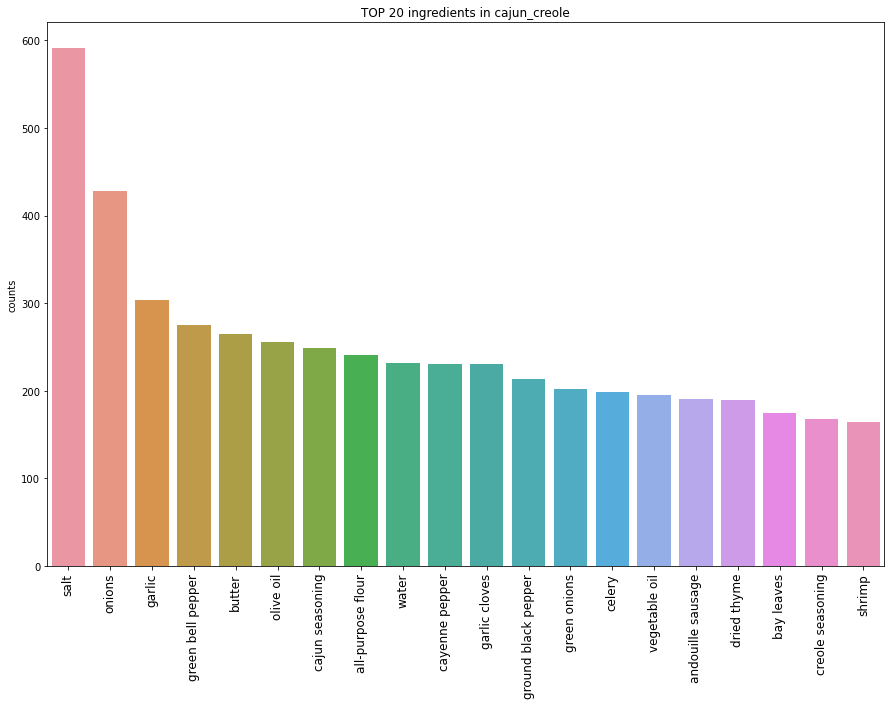

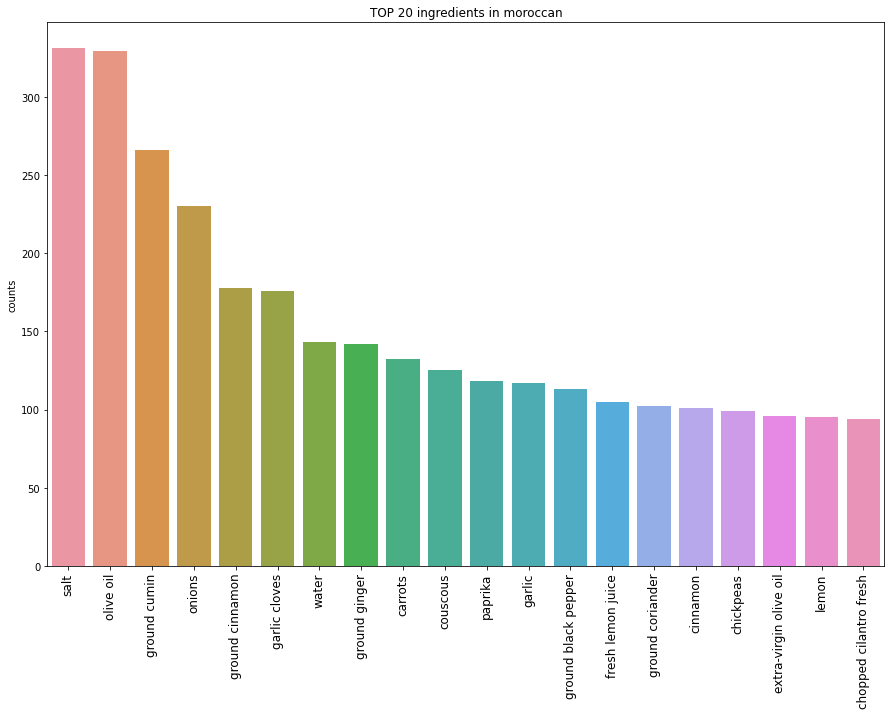

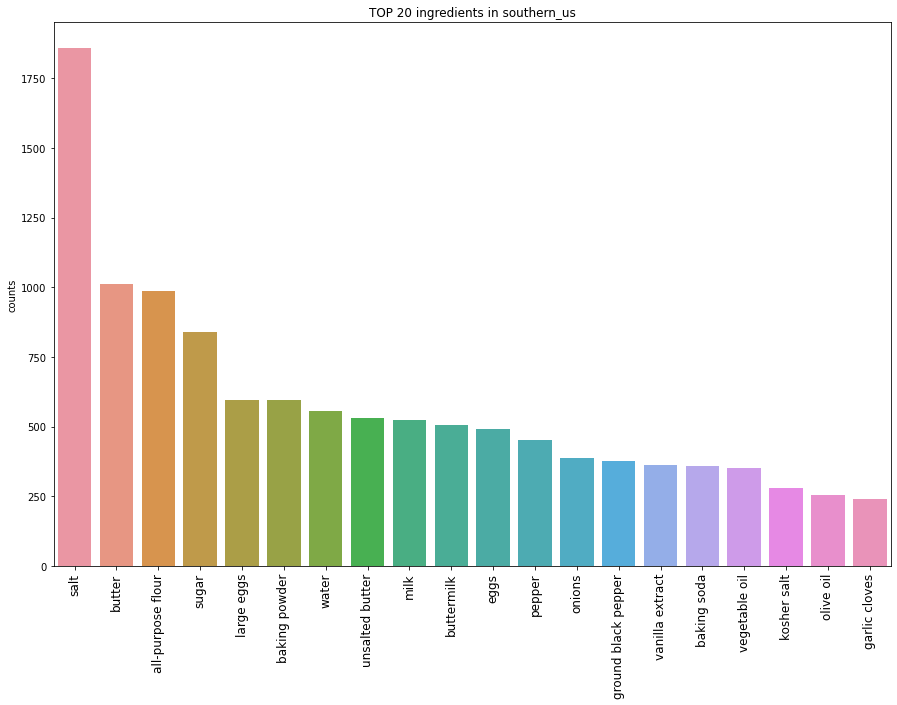

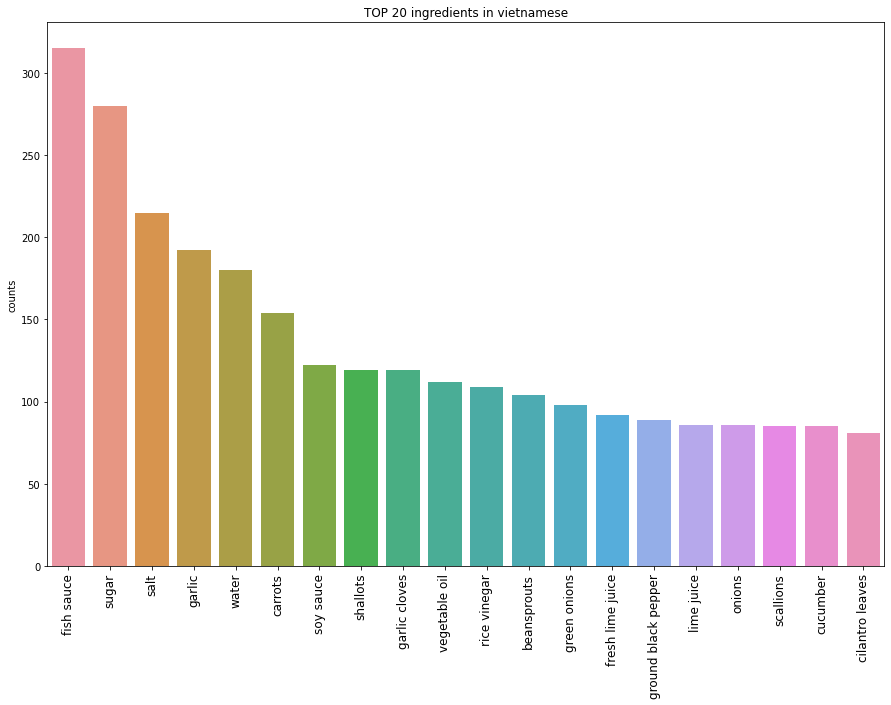

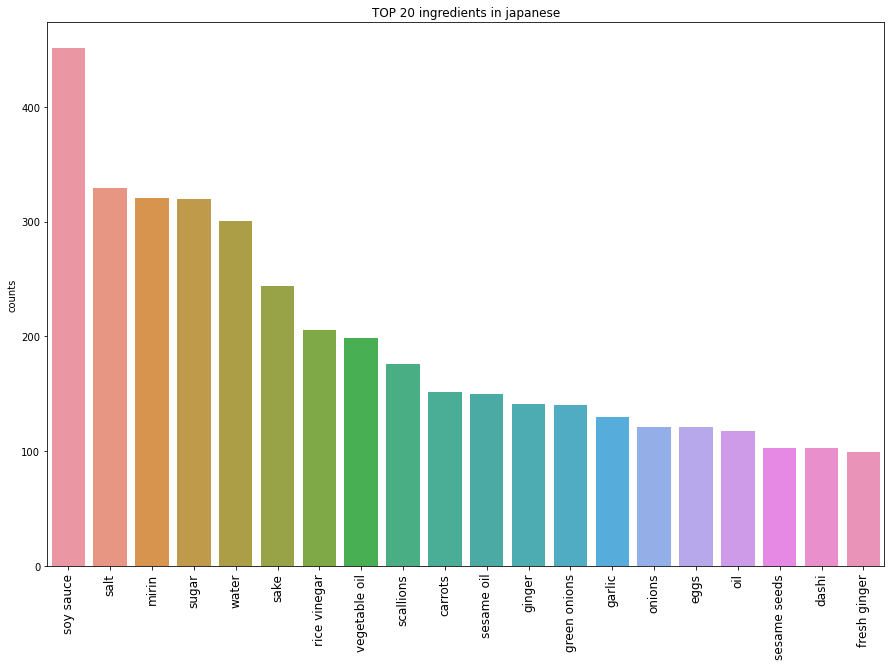

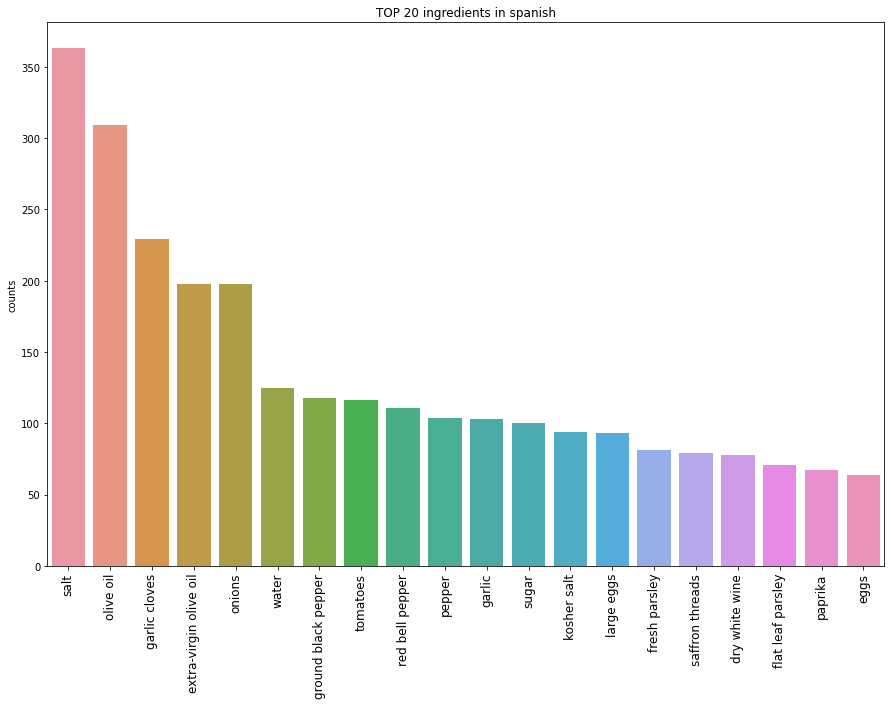

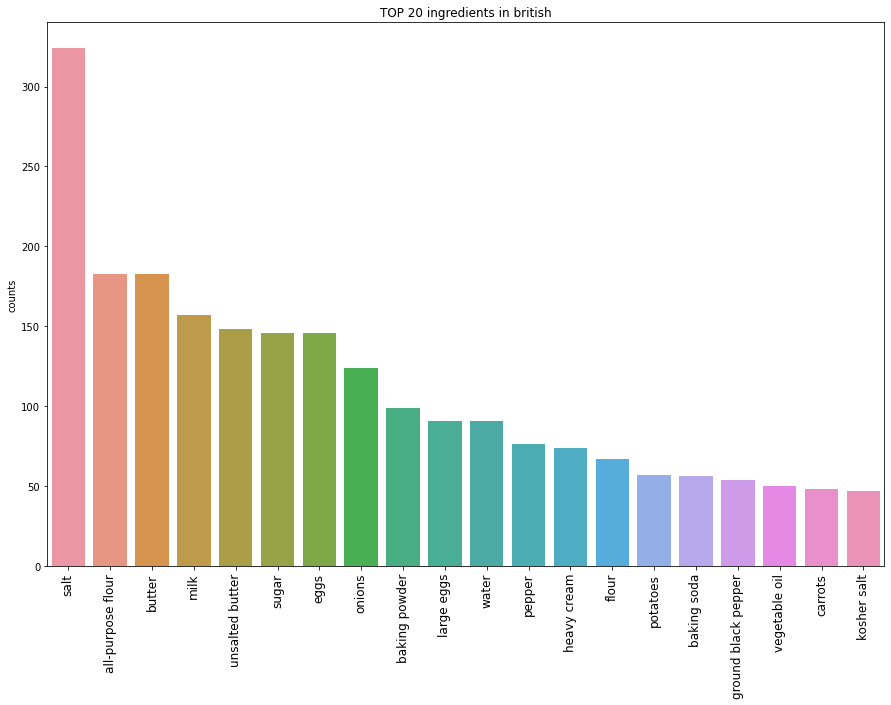

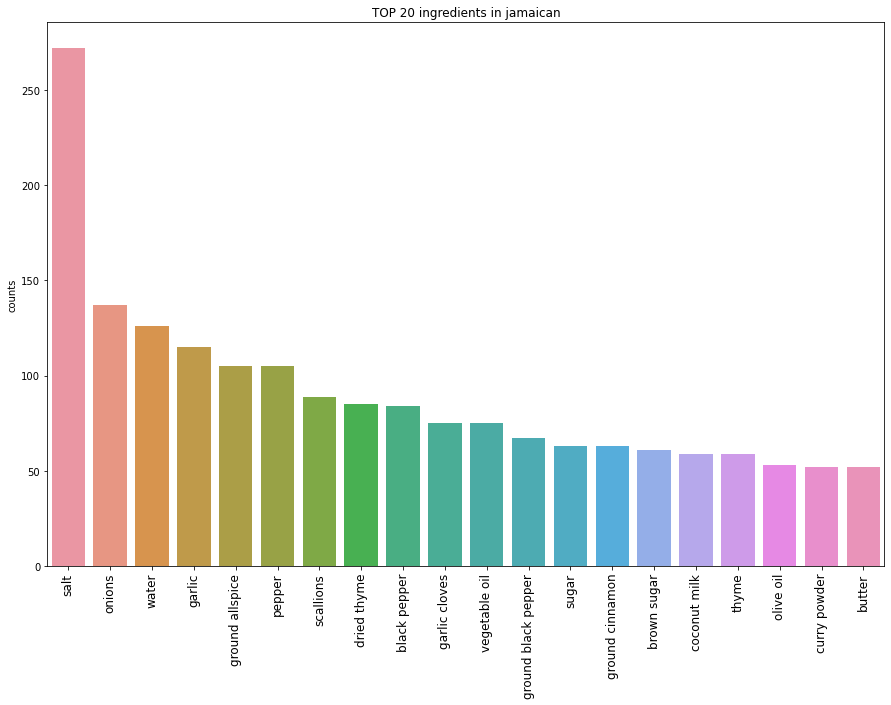

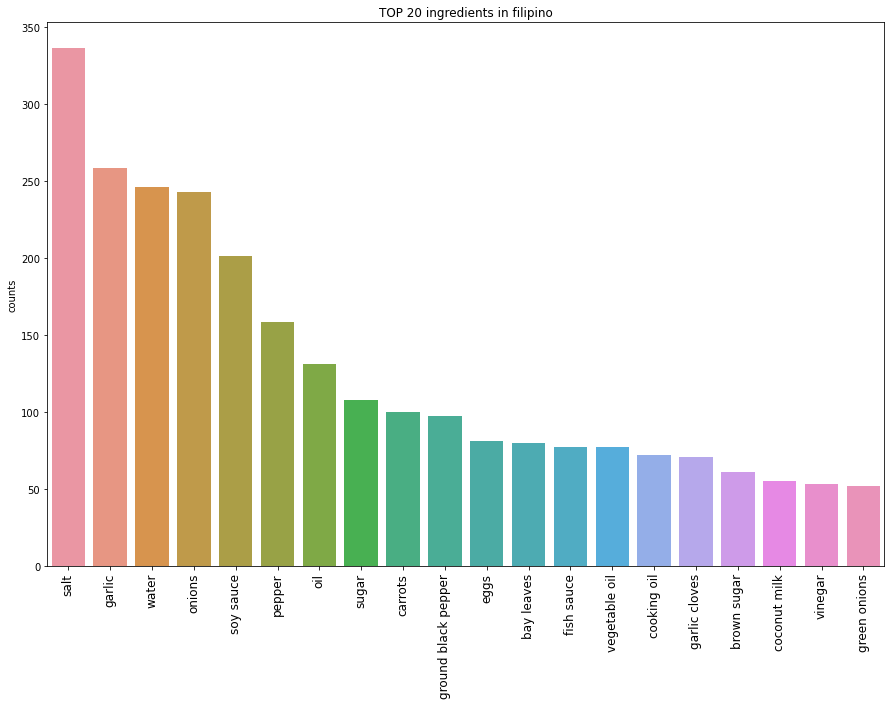

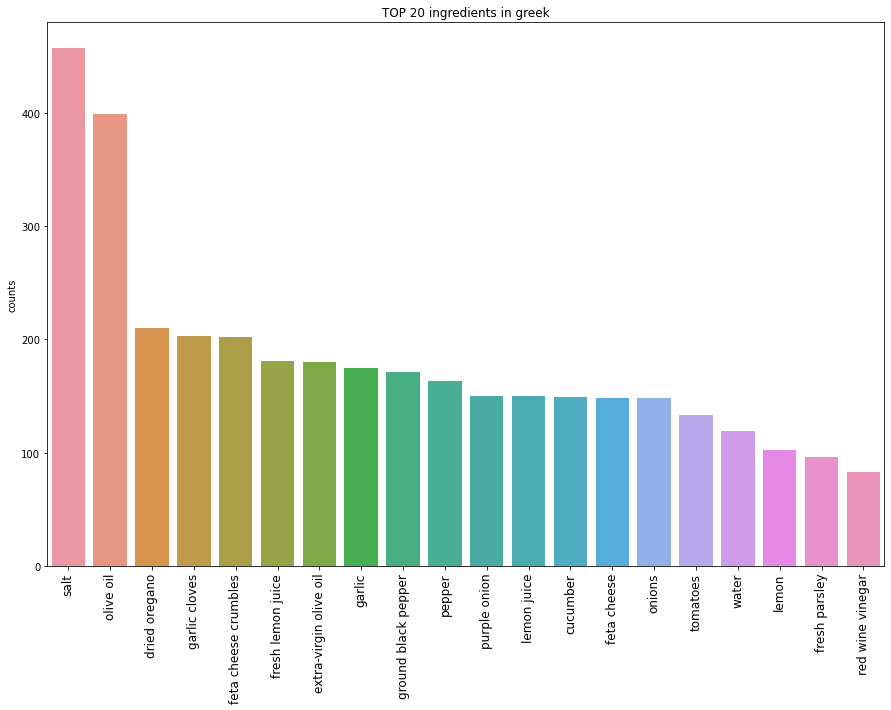

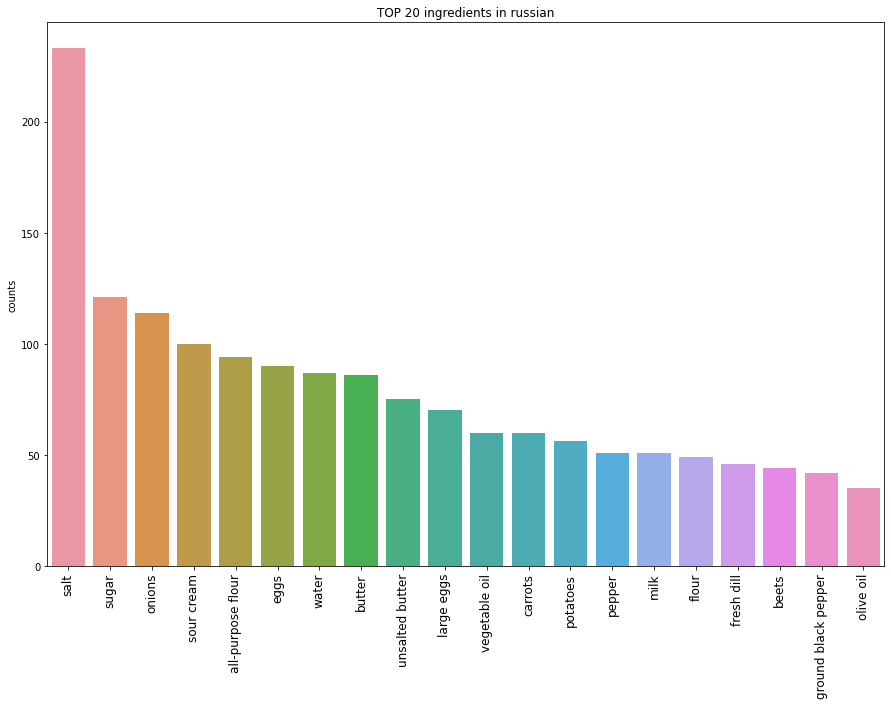

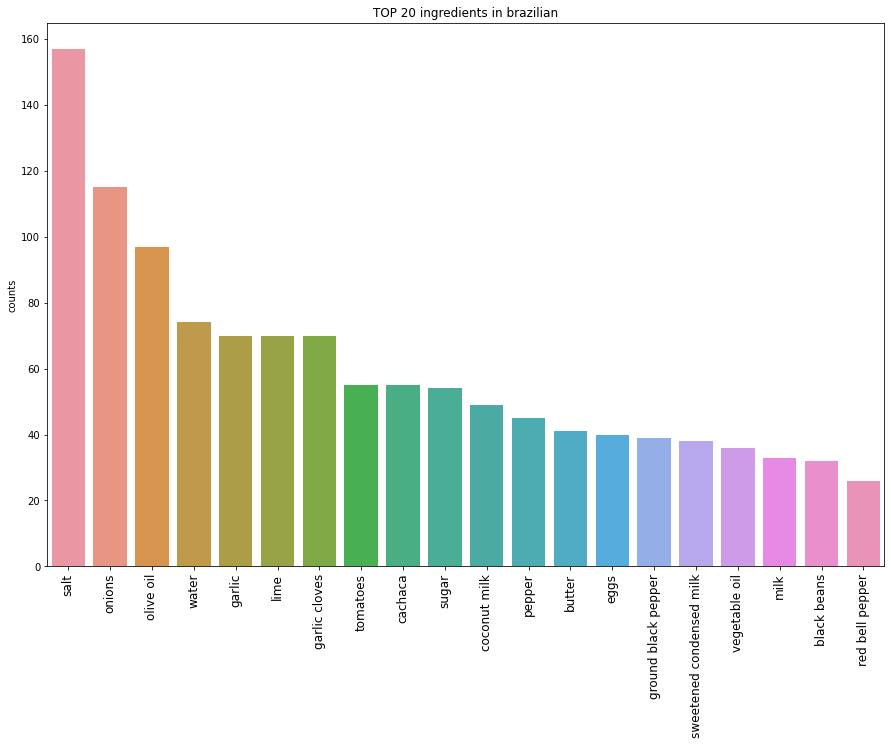

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_cuisine(df_train,country):
    all_ingredients = dict()
    df=df_train.copy()
    df = df[df['cuisine']==country]
    for per_cuisine in df['ingredients']:
        for per_ingredient in per_cuisine:
            if (per_ingredient in all_ingredients):
                all_ingredients[per_ingredient]+=1
            else:
                all_ingredients[per_ingredient]=1

    all_ingredients = dict(sorted(all_ingredients.items(), key=lambda all_ingredients: all_ingredients[1],reverse=True)[:20]) 
    all_ingredients_df= pd.DataFrame.from_dict(all_ingredients, orient='index').rename(columns={0:'counts'})
    # all_ingredients_df.sort_values(by=['counts'],ascending=False,inplace=True)
    plt.figure(figsize = (15,10))
    sns.barplot(x=all_ingredients_df['counts'][0:20].index,y=all_ingredients_df['counts'][0:20])
    plt.xticks(rotation = 90,fontsize = 12)
    plt.title('TOP 20 ingredients in {}'.format(country))
    # plt.savefig('.\eda\{}.png'.format(country),bbox_inches='tight')
    # plt.close()
    
    return all_ingredients

# EDA plot ,and save dict. to all ingredients in different country 
data = dict() # dict['country']['ingrdients']['counts']
for country in df_train.cuisine.unique():  
    data[country]=get_cuisine(df_train,country)


## Preprocessing

In [5]:
# preprocessing
def preprocess_df(df):
    nltk.download('wordnet')
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization ,list of ing.
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed |crumbles |ground |minced |powder |chopped |sliced ','', x), x)) # delete 處理方式,如:粉,丁,條狀..等等
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

train_pre = preprocess_df(df_train)
test_pre = preprocess_df(df_test)

X_train = train_pre['ingredients']
y_train = train_pre['cuisine']
X_test = test_pre['ingredients']
y_test = test_pre['cuisine']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Test Dimension

In [20]:
def tfidf_vectorizer(X, y=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    X = tfidf.fit_transform(X)
    if y is not None:
        y = tfidf.transform(y)
        return X, y
    else:
        return X

train_vec, test_vec = tfidf_vectorizer(X_train, X_test)
train_vec.shape

(7955, 2672)

## Model Development

In [8]:
# instantiate our pipeline
from sklearn.decomposition import TruncatedSVD
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SVMSMOTE

# pipe_params = {'vect__ngram_range':[(1, 1)],
#                'vect__max_features':[None],
#                'vect__stop_words':['english'],
#                'vect__max_df':[.57]
# #                'classify__C':[1]
# #                'decomp__n_components':[2000]
#                }

C = 604.5300203551828
gamma = 0.9656489284085462
param = {}

# pipe = Pipeline([('vect', TfidfVectorizer(token_pattern=r'\w+')),
#                  ('resample', SVMSMOTE()),
#                  ('classify', SVC(C=float(C), gamma=float(gamma), kernel='rbf'))])
# clf = GridSearchCV(pipe, pipe_params, refit = True, verbose = 3, n_jobs=-1)
# train_vec = TfidfVectorizer(token_pattern=r'\w+').fit_transform(train)

X_resampled, y_resampled = SVMSMOTE(random_state=2).fit_resample(train_vec, y_train)

clf = GridSearchCV(SVC(C=float(C), gamma=float(gamma), kernel='rbf'), param, refit = True, verbose = 3, n_jobs=-1)
clf.fit(X_resampled, y_resampled)

print("CV score {:.4f}".format(clf.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV score 0.9789


In [21]:
y_pred = clf.predict(test_vec)

## Evaluation

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31819 samples in 0.012s...
[t-SNE] Computed neighbors for 31819 samples in 45.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31819
[t-SNE] Computed conditional probabilities for sample 2000 / 31819
[t-SNE] Computed conditional probabilities for sample 3000 / 31819
[t-SNE] Computed conditional probabilities for sample 4000 / 31819
[t-SNE] Computed conditional probabilities for sample 5000 / 31819
[t-SNE] Computed conditional probabilities for sample 6000 / 31819
[t-SNE] Computed conditional probabilities for sample 7000 / 31819
[t-SNE] Computed conditional probabilities for sample 8000 / 31819
[t-SNE] Computed conditional probabilities for sample 9000 / 31819
[t-SNE] Computed conditional probabilities for sample 10000 / 31819
[t-SNE] Computed conditional probabilities for sample 11000 / 31819
[t-SNE] Computed conditional probabilities for sample 12000 / 31819
[t-SNE] Computed conditional probabilities for sa

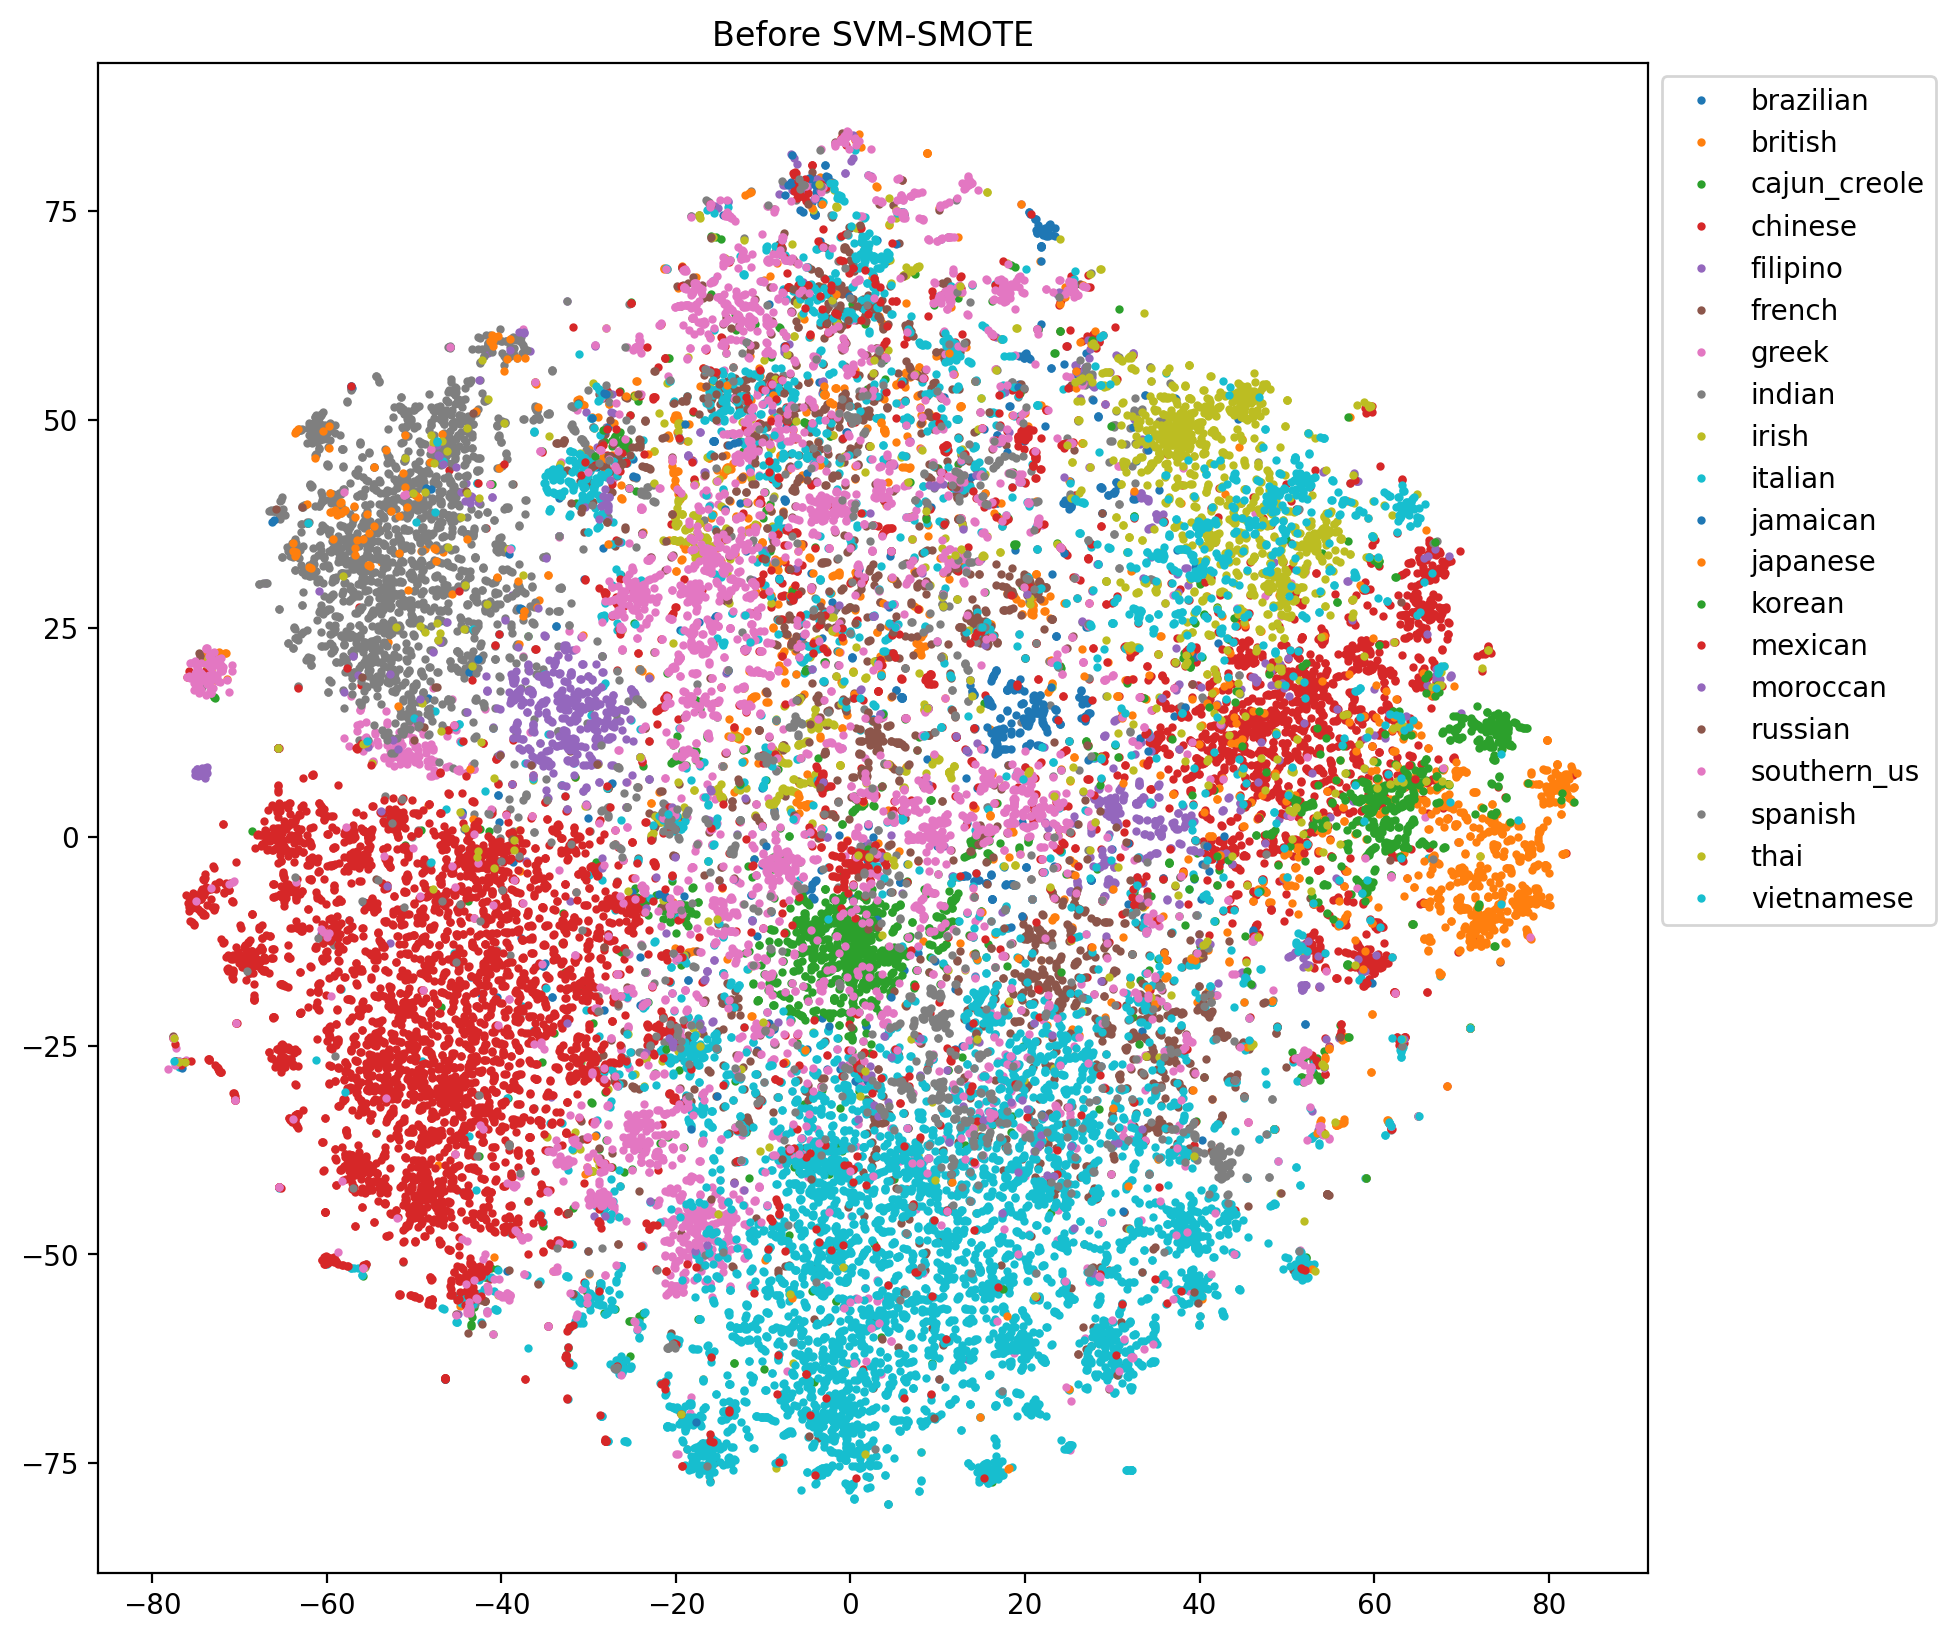

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 125400 samples in 0.052s...
[t-SNE] Computed neighbors for 125400 samples in 815.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 125400
[t-SNE] Computed conditional probabilities for sample 2000 / 125400
[t-SNE] Computed conditional probabilities for sample 3000 / 125400
[t-SNE] Computed conditional probabilities for sample 4000 / 125400
[t-SNE] Computed conditional probabilities for sample 5000 / 125400
[t-SNE] Computed conditional probabilities for sample 6000 / 125400
[t-SNE] Computed conditional probabilities for sample 7000 / 125400
[t-SNE] Computed conditional probabilities for sample 8000 / 125400
[t-SNE] Computed conditional probabilities for sample 9000 / 125400
[t-SNE] Computed conditional probabilities for sample 10000 / 125400
[t-SNE] Computed conditional probabilities for sample 11000 / 125400
[t-SNE] Computed conditional probabilities for sample 12000 / 125400
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 125400
[t-SNE] Computed conditional probabilities for sample 119000 / 125400
[t-SNE] Computed conditional probabilities for sample 120000 / 125400
[t-SNE] Computed conditional probabilities for sample 121000 / 125400
[t-SNE] Computed conditional probabilities for sample 122000 / 125400
[t-SNE] Computed conditional probabilities for sample 123000 / 125400
[t-SNE] Computed conditional probabilities for sample 124000 / 125400
[t-SNE] Computed conditional probabilities for sample 125000 / 125400
[t-SNE] Computed conditional probabilities for sample 125400 / 125400
[t-SNE] Mean sigma: 0.315450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.743454
[t-SNE] KL divergence after 1000 iterations: 3.256060


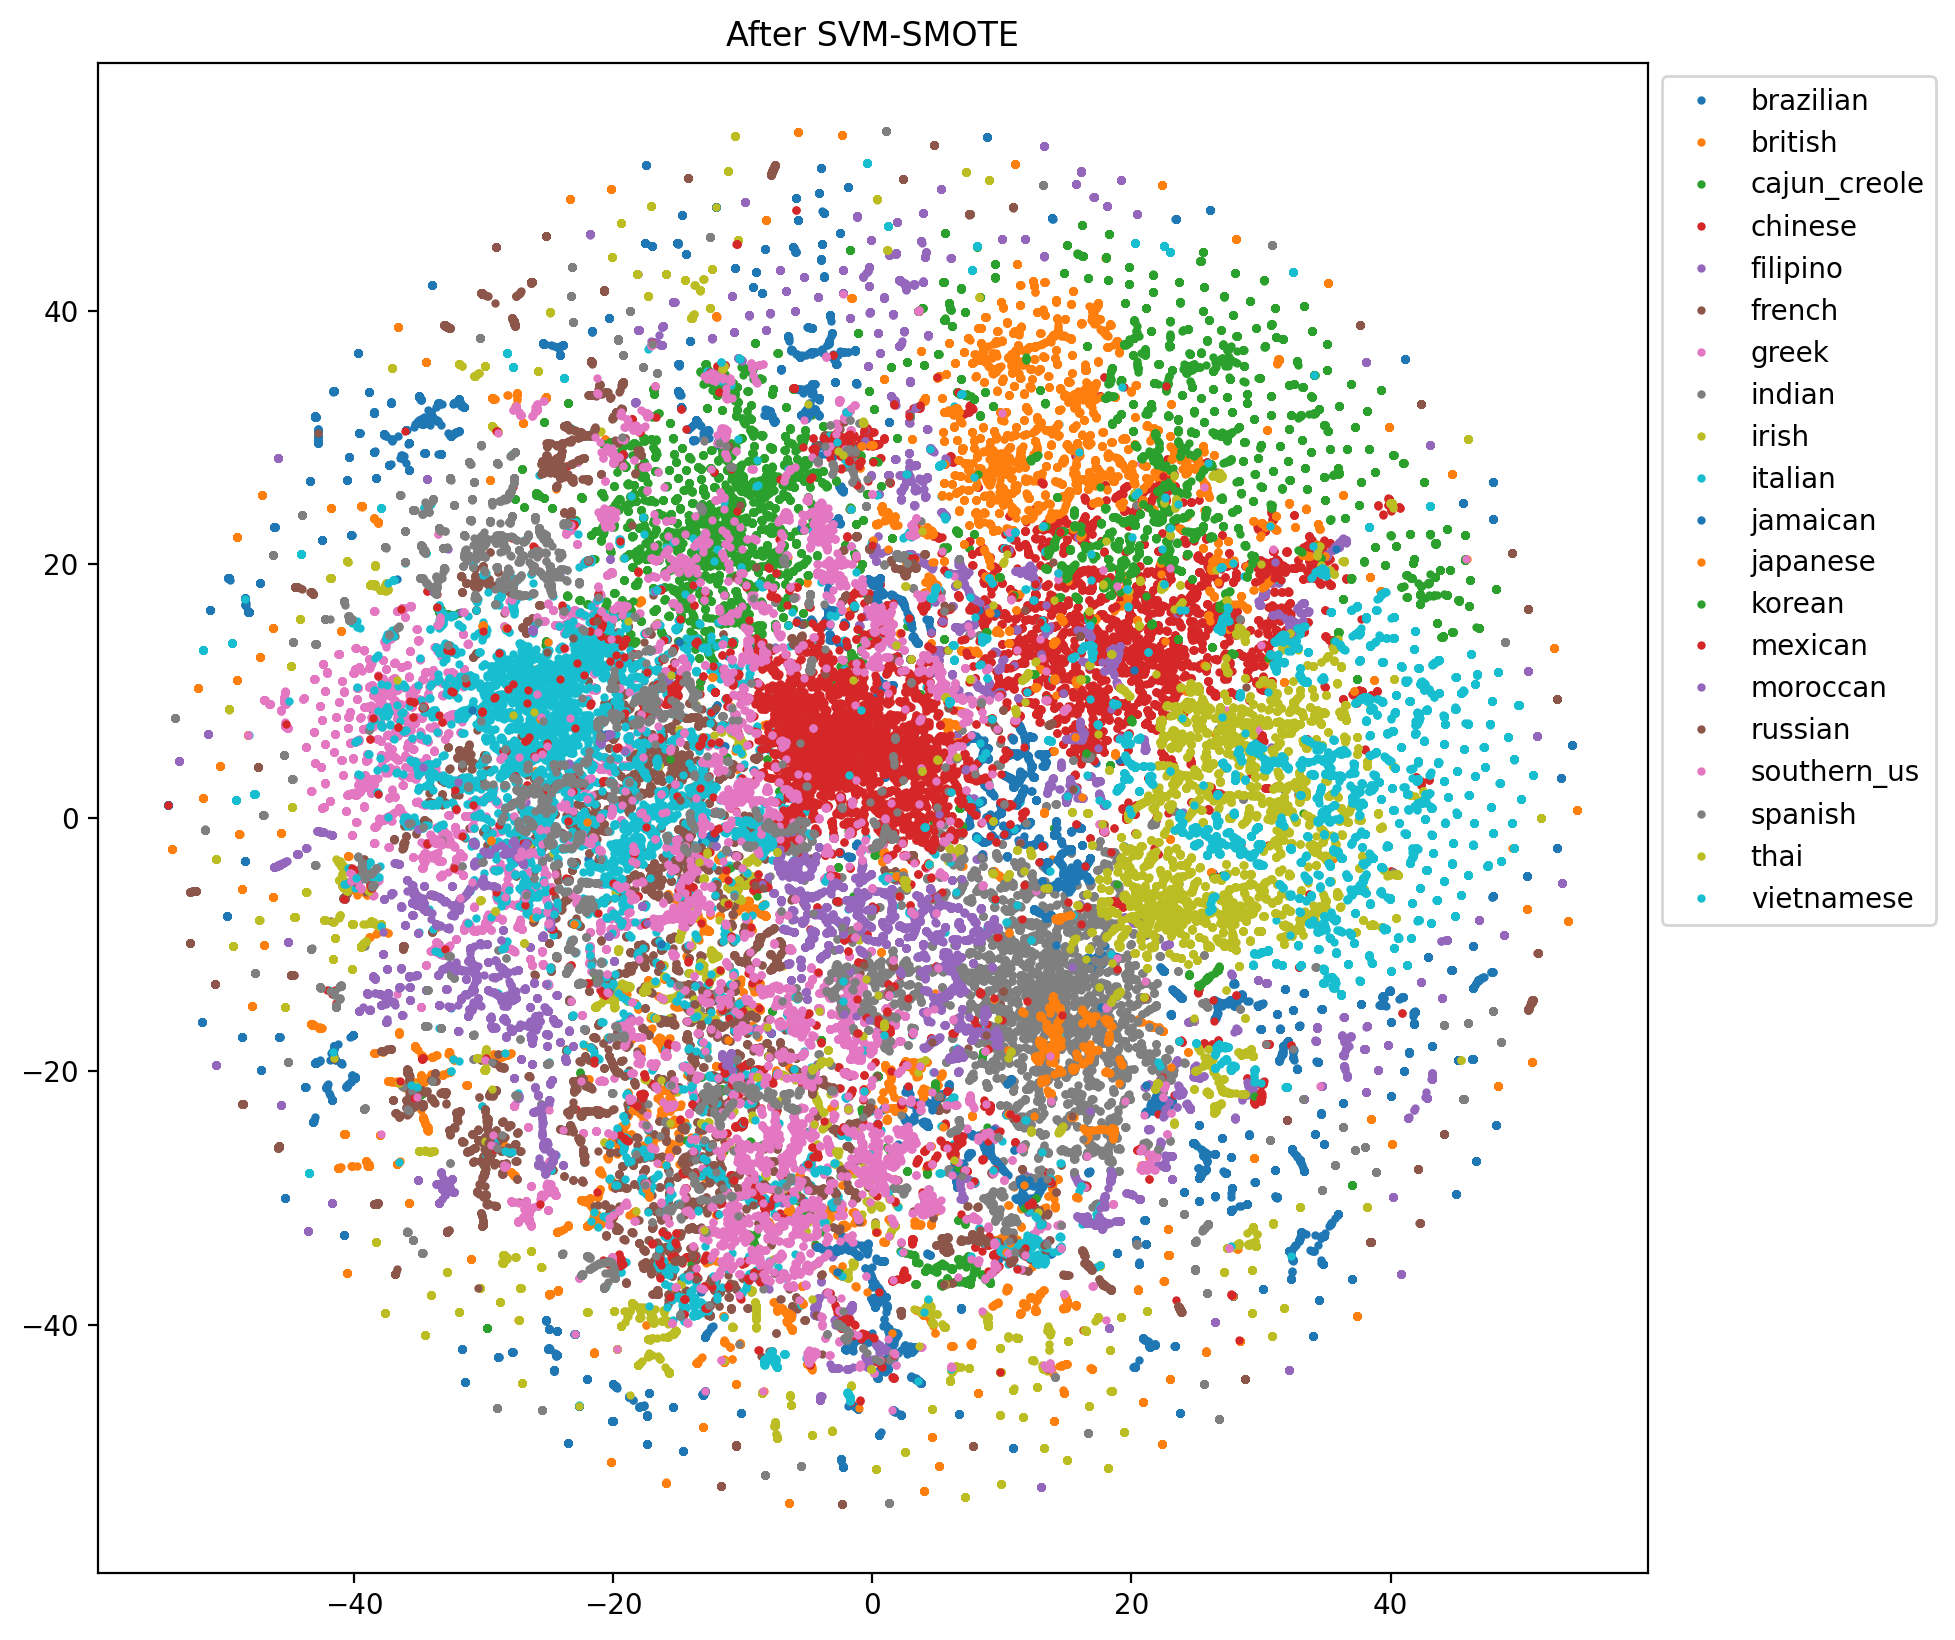

In [24]:
from sklearn.manifold import TSNE

def Visual_SMOTE(X,y,resampled):
    X_tsne = TSNE(n_components=2,verbose=1).fit_transform(X)
    df = pd.DataFrame(dict(x=X_tsne[:,0], y=X_tsne[:,1], label=y))
    groups = df.groupby('label')

    f = plt.figure(figsize=(10, 10),dpi=200)
    ax = f.add_subplot(111)

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=2, label=name)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    if resampled:
        plt.title('After SVM-SMOTE')
    else:
        plt.title('Before SVM-SMOTE')

    plt.show()
    
Visual_SMOTE(train_vec,y_train,resampled=False)
Visual_SMOTE(X_resampled,y_resampled,resampled=True)

### Score

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_true = y_test
print("Accuarcy\t {:.4f}".format(accuracy_score(y_true, y_pred)))
print("F1-micro\t {:.4f}".format(f1_score(y_true, y_pred, average='micro')))
print("F1-macro\t {:.4f}".format(f1_score(y_true, y_pred, average='macro')))
print("F1-weighted\t {:.4f}".format(f1_score(y_true, y_pred, average='weighted')))

# print(classification_report(y_true, y_pred))

Accuarcy	 0.8068
F1-micro	 0.8068
F1-macro	 0.7491
F1-weighted	 0.8050


### Confusion Matrix

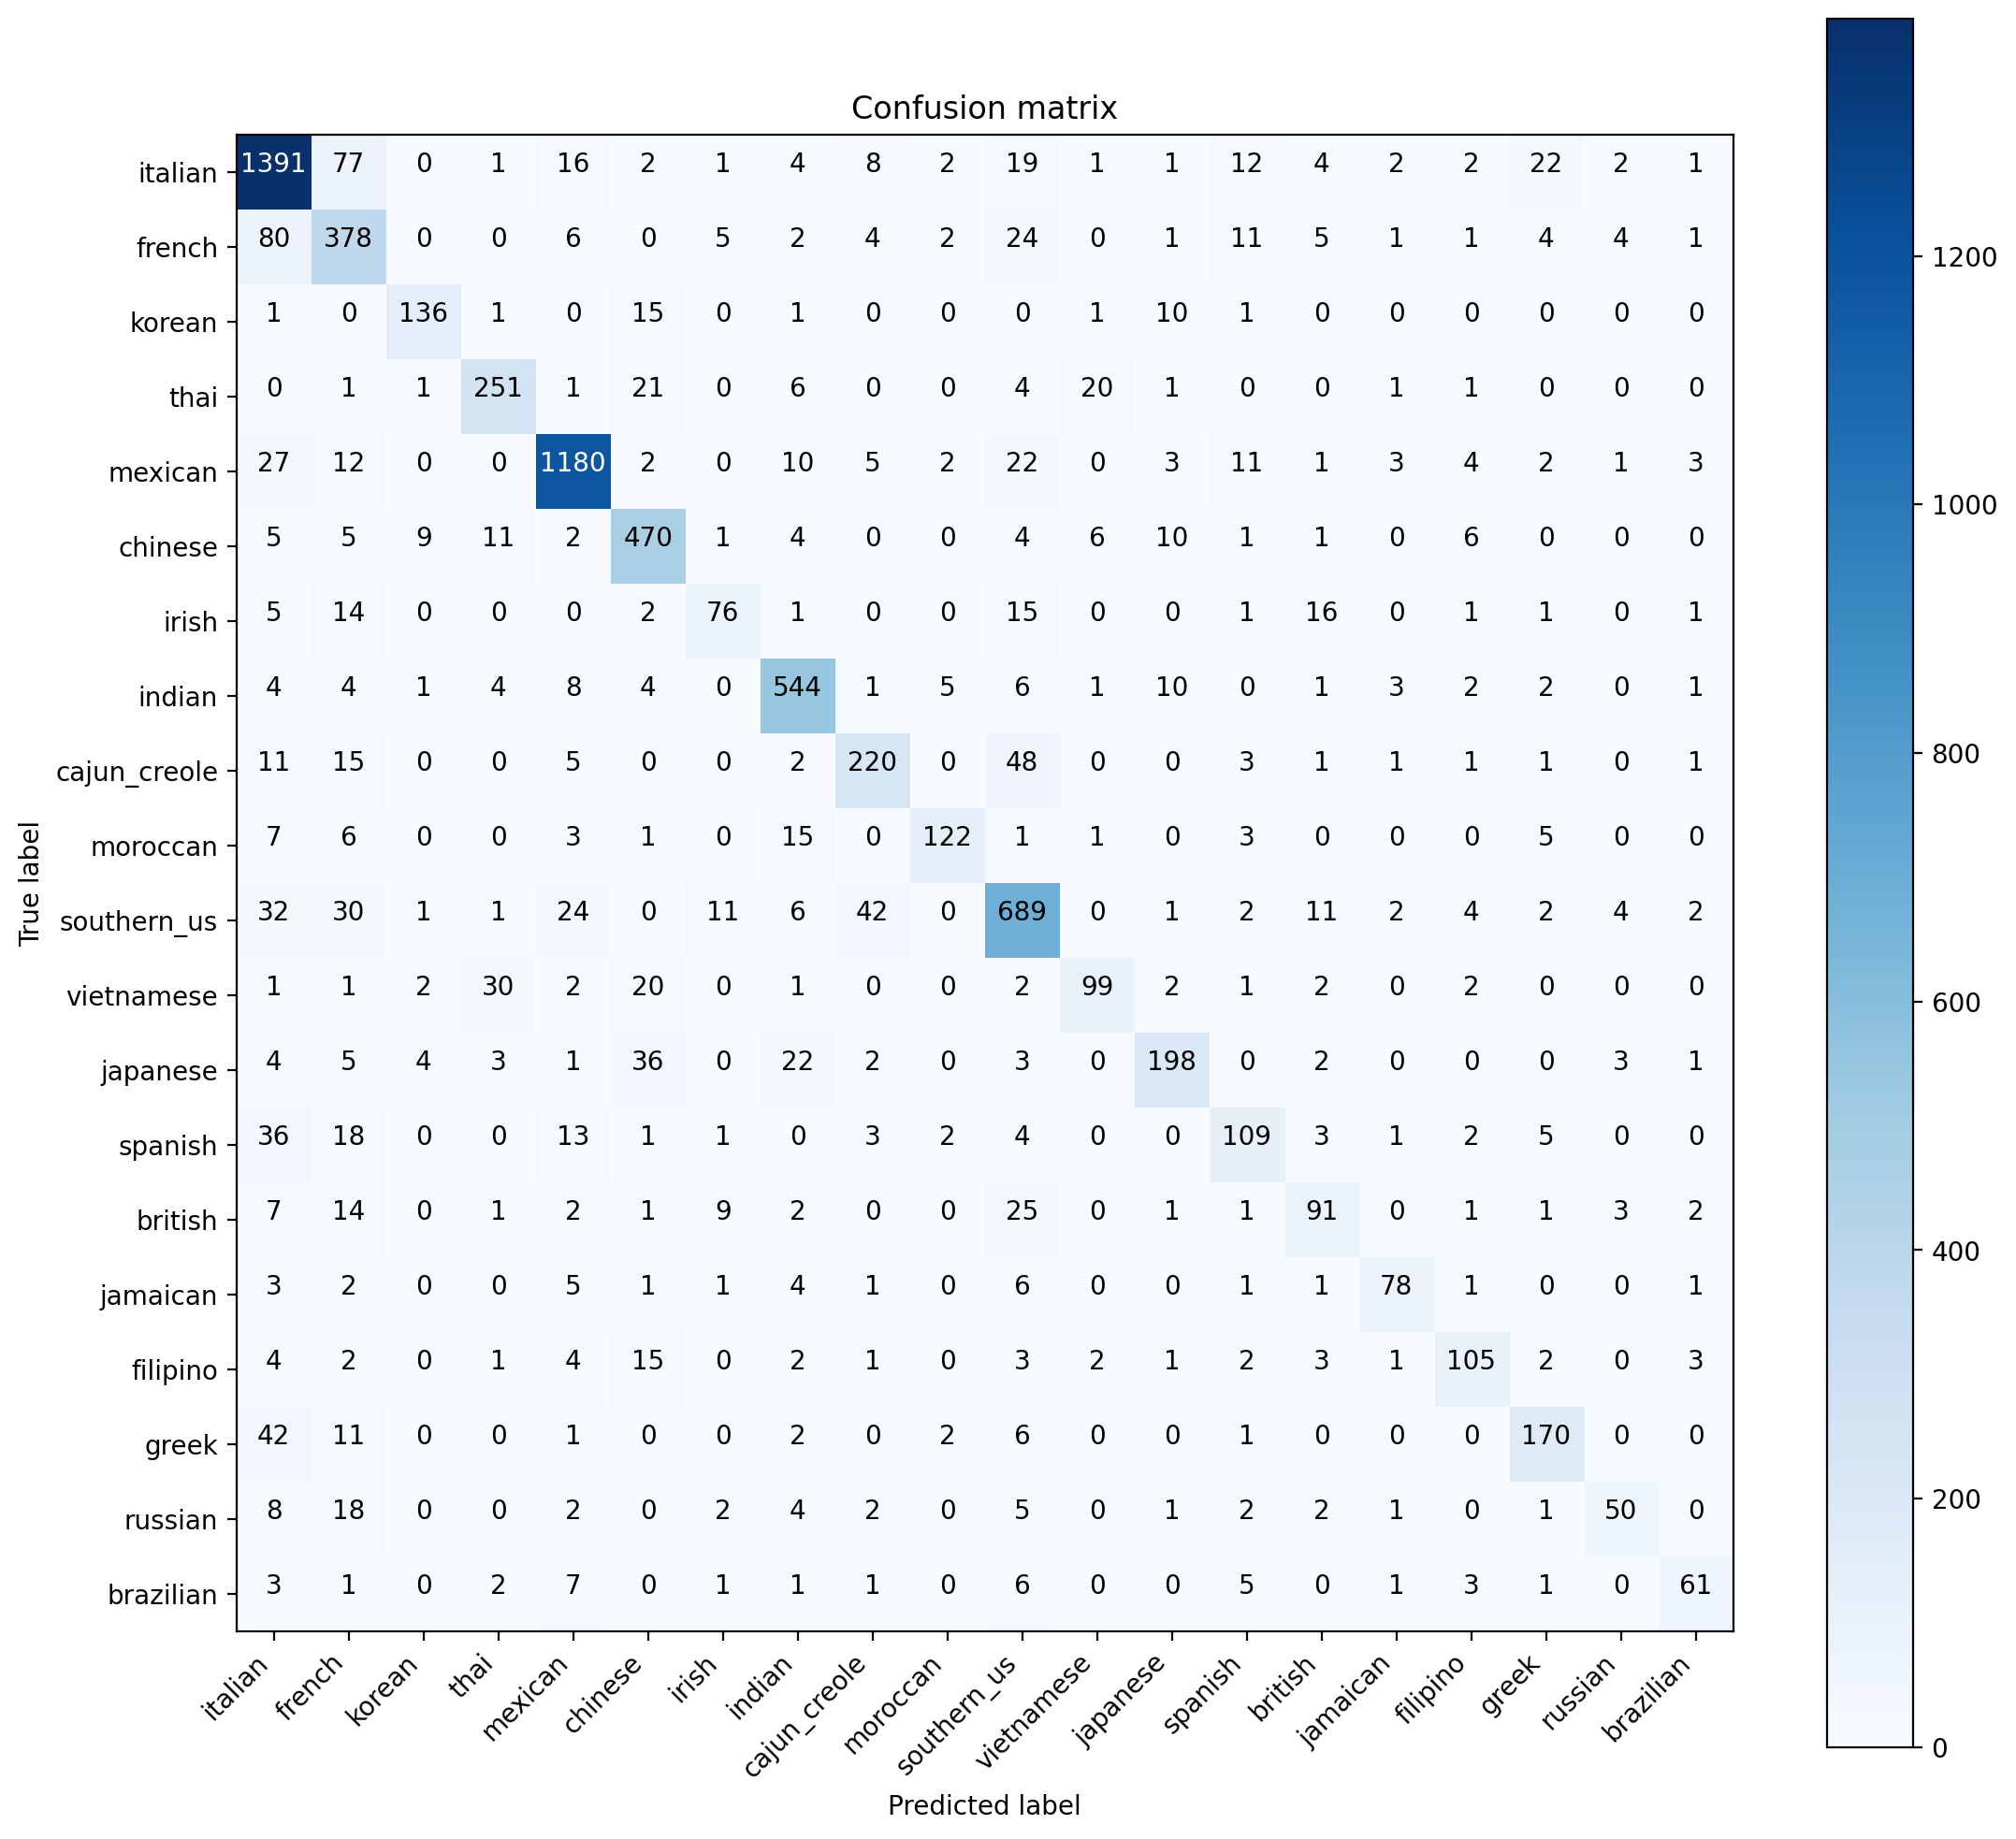

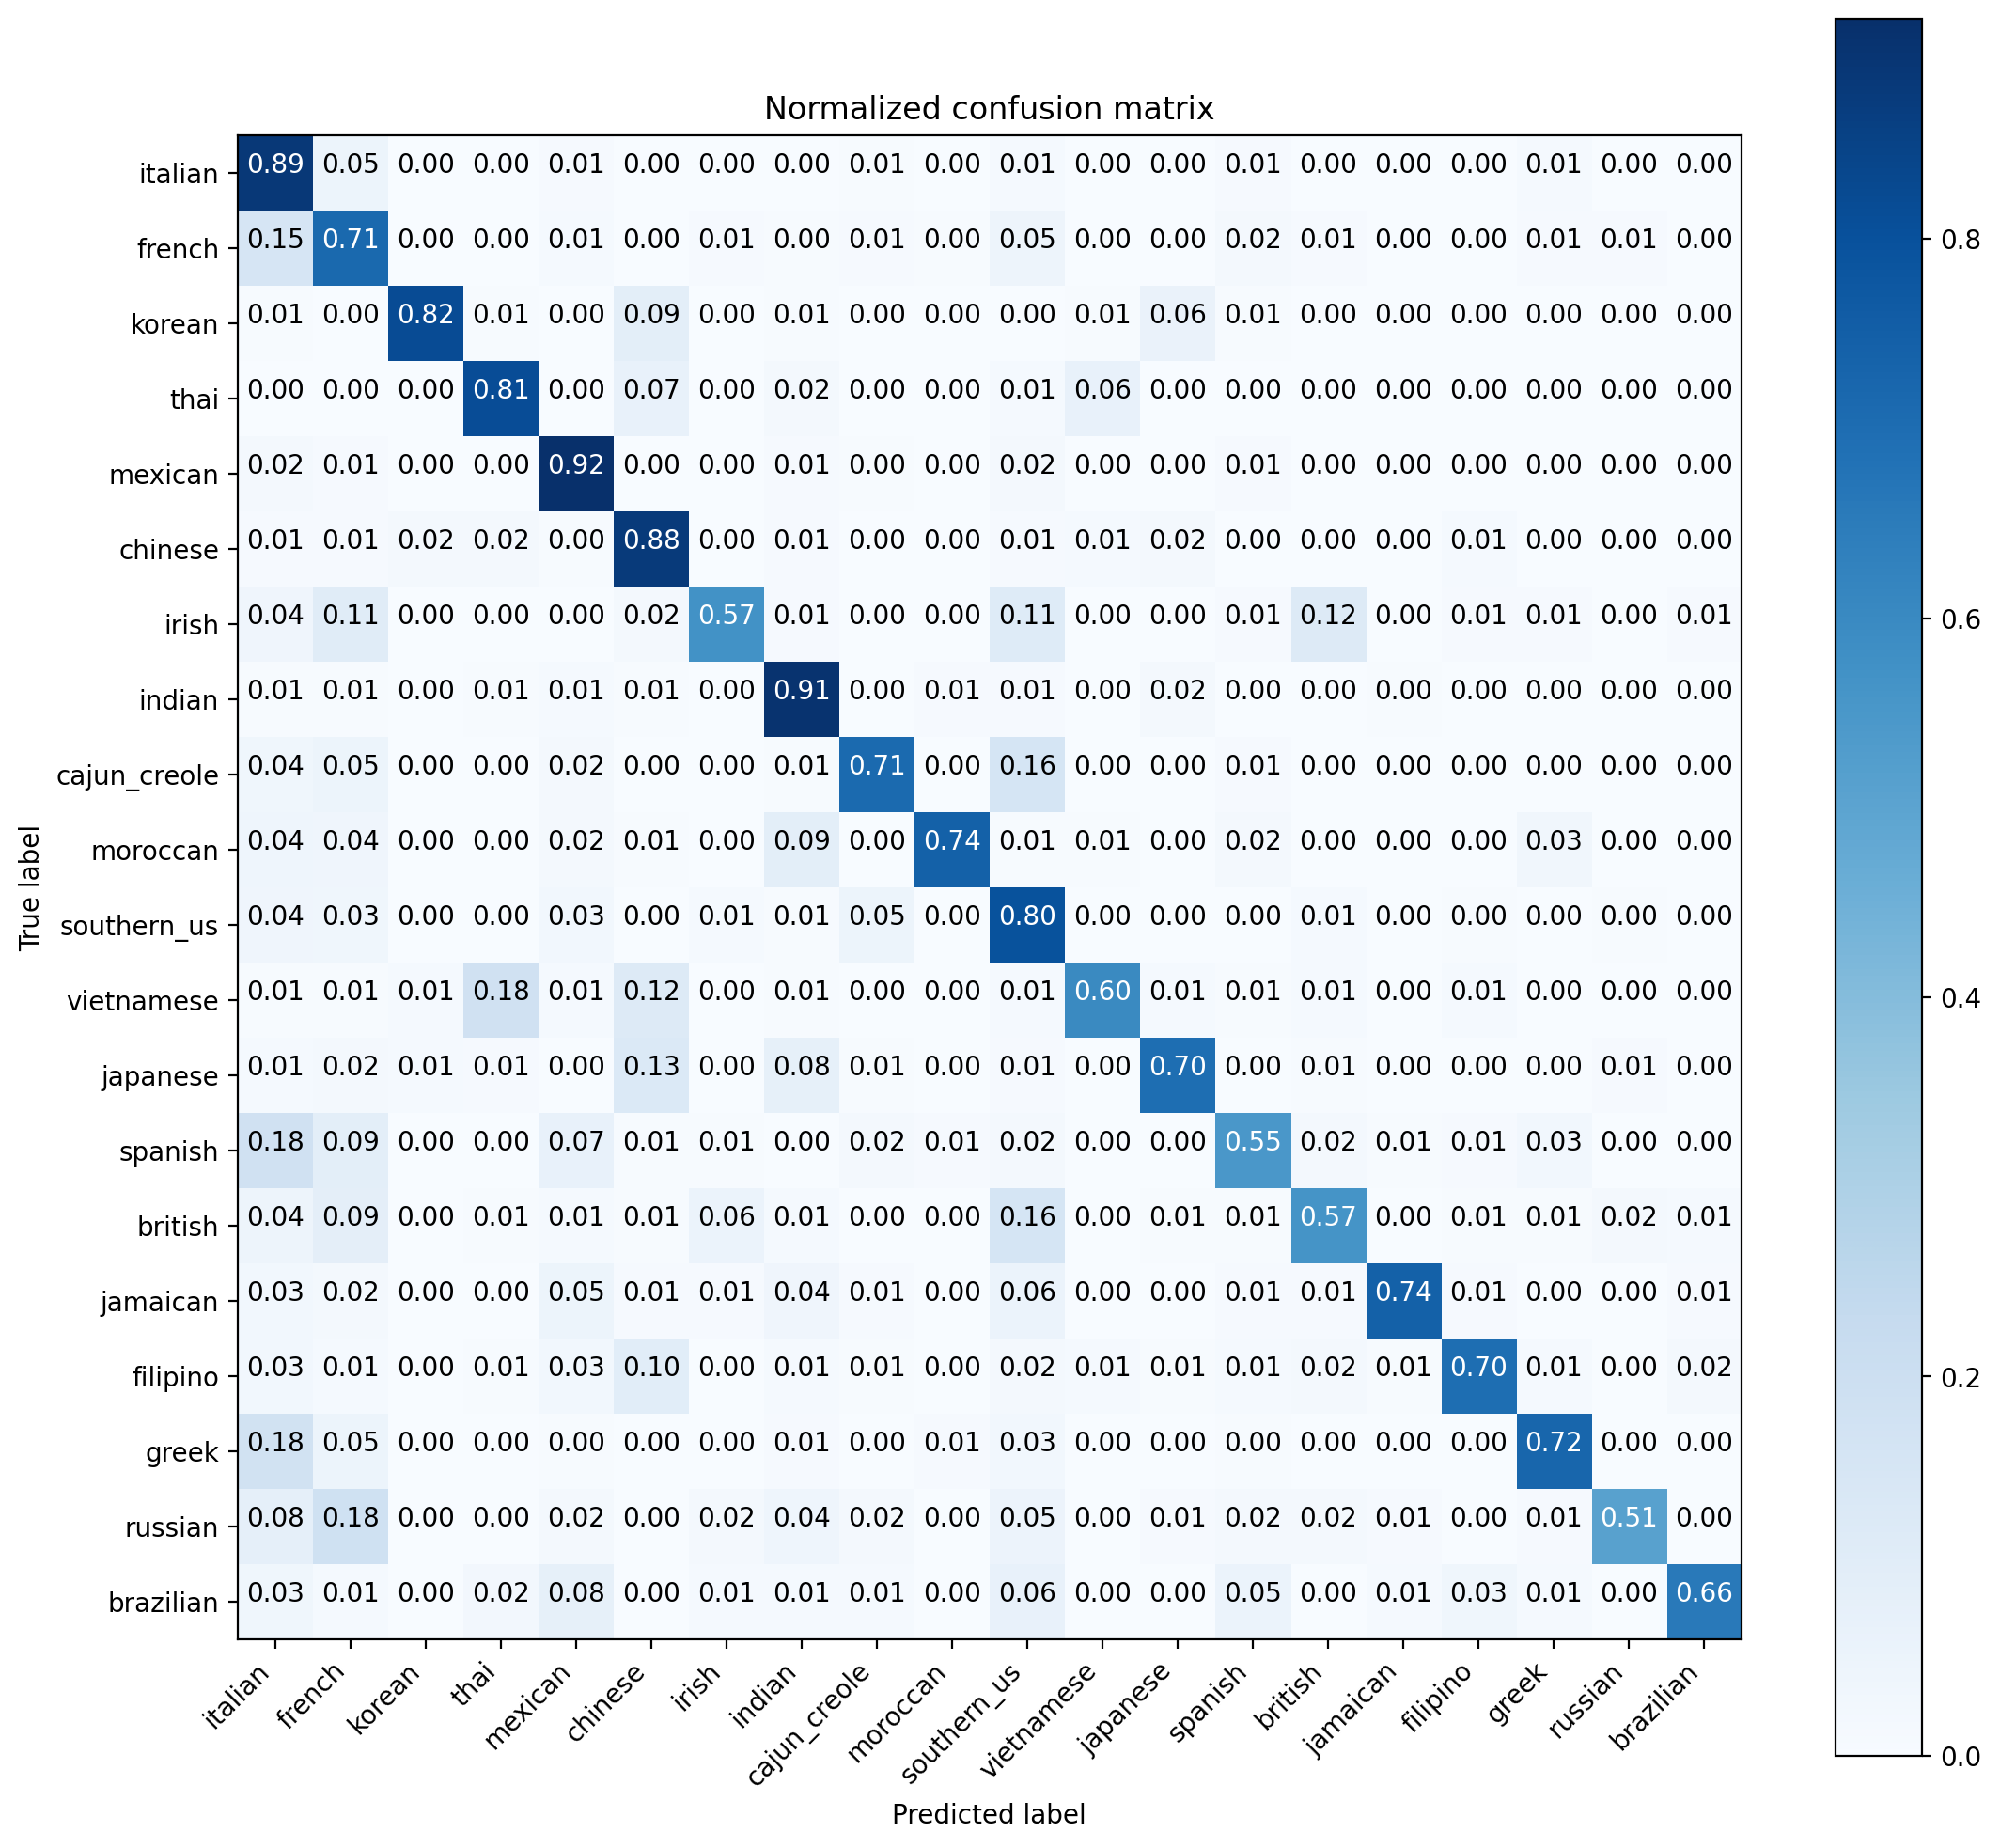

In [26]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def my_plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true,y_pred,labels=classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    leftmargin = 0.5
    rightmargin = 0.5
    categorysize = 0.5
    figwidth = leftmargin + rightmargin + (len(classes) * categorysize)           

    f = plt.figure(figsize=(figwidth, figwidth),dpi=200)

    ax = f.add_subplot(111)
    ax.set_aspect(1)
    f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=0.94, bottom=0.1)

    res = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar(res)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()


my_plot_confusion_matrix(y_true, y_pred, cs_list, normalize=False, cmap=plt.cm.Blues)
my_plot_confusion_matrix(y_true, y_pred, cs_list, normalize=True, cmap=plt.cm.Blues)

In [ ]:
# test_id = df_test['id']
# my_submission = pd.DataFrame({'id':test_id})
# my_submission['cuisine'] = y_pred
# my_submission.to_csv('submission.csv', index=False)
# print('Saved file to disk as submission.csv.')